In [18]:
# Requirements:
# pip install pandas numpy matplotlib seaborn statsmodels scikit-learn gdown

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Helper: download from Drive (uses direct uc link)
def download_from_drive(file_id, out_path):
    url = f"https://drive.google.com/uc?id={file_id}&export=download"
    # pandas can read directly but if file large you may want to use requests or gdown
    df = pd.read_csv(url)
    df.to_csv(out_path, index=False)
    return df

# 1) Load files (will read directly from Drive)
hist_file_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
fg_file_id   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

hist = download_from_drive(hist_file_id, "historical_trades.csv")
fg   = download_from_drive(fg_file_id, "fear_greed.csv")

# Quick peek
print(hist.shape, fg.shape)
print(hist.columns)
print(fg.columns)


(211224, 16) (2644, 4)
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [19]:
# Convert times to datetime
# Adjust column names if needed
time_cols = ['time','timestamp','datetime']  # pick the actual column in your dataset

# pick the first available time-like column from hist
candidate_cols = time_cols + ['Timestamp', 'Timestamp IST']
time_col = next((c for c in candidate_cols if c in hist.columns), None)

if time_col is None:
    raise KeyError(f"No time column found in hist. Checked: {candidate_cols}")

# convert depending on dtype and value scale (seconds vs milliseconds)
if np.issubdtype(hist[time_col].dtype, np.number):
    max_val = hist[time_col].max()
    # heuristics: values >1e12 -> milliseconds, >1e9 -> seconds
    if max_val > 1e12:
        unit = 'ms'
    elif max_val > 1e9:
        unit = 's'
    else:
        unit = 's'
    hist['time_dt'] = pd.to_datetime(hist[time_col], unit=unit, origin='unix', errors='coerce')
else:
    hist['time_dt'] = pd.to_datetime(hist[time_col], errors='coerce')

# create date key (UTC date)
hist['date'] = hist['time_dt'].dt.date

# For Fear & Greed dataset: normalize column names and convert
# handle lowercase/uppercase variants in fg
if 'date' in fg.columns:
    fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
elif 'Date' in fg.columns:
    fg['date'] = pd.to_datetime(fg['Date'], errors='coerce').dt.date

if 'classification' in fg.columns:
    fg.rename(columns={'classification': 'sentiment'}, inplace=True)
elif 'Classification' in fg.columns:
    fg.rename(columns={'Classification': 'sentiment'}, inplace=True)

# Inspect missingness and report which column was used
print("hist time column used:", time_col)
print(hist[['time_dt', 'date']].head())
print(hist.isna().sum())
print(fg.isna().sum())


hist time column used: Timestamp
              time_dt        date
0 2024-10-27 03:33:20  2024-10-27
1 2024-10-27 03:33:20  2024-10-27
2 2024-10-27 03:33:20  2024-10-27
3 2024-10-27 03:33:20  2024-10-27
4 2024-10-27 03:33:20  2024-10-27
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
time_dt             0
date                0
dtype: int64
timestamp    0
value        0
sentiment    0
date         0
dtype: int64


In [20]:
# Basic metrics per day (aggregated across all accounts) — adjust columns (closedPnL, side, size, leverage)
# The hist dataframe may use different column names (e.g. "Account", "Closed PnL", "Size USD", "Size Tokens").
# Find best-matching actual columns in hist and build an aggregation dict from the existing agg_funcs.

def _find_col(df, candidates):
    """Case/space/underscore-insensitive lookup for a column in df.
    candidates may be a single string or list of strings to try in order.
    Returns the actual column name or None."""
    if isinstance(candidates, str):
        candidates = [candidates]
    norm_map = {c: c.lower().replace(' ', '').replace('_', '') for c in df.columns}
    # exact normalized match first
    for cand in candidates:
        target = cand.lower().replace(' ', '').replace('_', '')
        for col, norm in norm_map.items():
            if norm == target:
                return col
    # fallback: substring match
    for cand in candidates:
        target = cand.lower().replace(' ', '').replace('_', '')
        for col, norm in norm_map.items():
            if target in norm or norm in target:
                return col
    return None

# candidate names to try for each logical field
_candidates = {
    'account': ['account', 'Account'],
    'closedPnL': ['closedPnL', 'Closed PnL', 'Closed Pnl', 'ClosedPnL'],
    'size': ['size', 'Size', 'Size USD', 'Size_Tokens', 'Size Tokens'],
    'leverage': ['leverage', 'Leverage']
}

# Build mapping of logical -> actual column names (or None)
col_map = {k: _find_col(hist, v) for k, v in _candidates.items()}

# Build new aggregation dictionary by mapping keys in agg_funcs to actual hist columns
new_agg = {}
for logical_col, funcs in agg_funcs.items():
    actual_col = col_map.get(logical_col)
    if actual_col and actual_col in hist.columns:
        new_agg[actual_col] = funcs
    else:
        print(f"Warning: could not find a column for '{logical_col}' (checked candidates {_candidates.get(logical_col)}). Skipping it.")

if not new_agg:
    raise KeyError(f"No matching columns found for aggregation. Column map: {col_map}")

daily = hist.groupby('date').agg(new_agg)

# flatten columns (handle both MultiIndex and single-level)
daily.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in daily.columns.values
]
daily = daily.reset_index().rename(columns={'date': 'Date'})

# Win rate: fraction of trades with closedPnL > 0 (only if we found the closedPnL column)
closed_actual = col_map.get('closedPnL')
if closed_actual:
    hist['win'] = hist[closed_actual] > 0
    winrate = hist.groupby('date')['win'].mean().reset_index().rename(columns={'win': 'win_rate'})
    daily = daily.merge(winrate, left_on='Date', right_on='date', how='left').drop(columns=['date'])
else:
    print("Warning: closedPnL column not found; win rate not computed.")

daily['Date'] = pd.to_datetime(daily['Date']).dt.date


In [21]:
# Ensure fg has a 'Date' column (daily uses 'Date' capitalized)
if 'Date' not in fg.columns:
    if 'date' in fg.columns:
        fg['Date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
    else:
        raise KeyError("fg does not contain either 'Date' or 'date' columns for merging.")

merged = pd.merge(daily, fg[['Date', 'sentiment']], on='Date', how='left')

# Create lagged sentiment columns (e.g., sentiment t-1, t-2) using vectorized ops
merged['Date_dt'] = pd.to_datetime(merged['Date'])
for lag in [1, 2, 3, 7]:
    lag_col = f'sentiment_lag_{lag}'
    # vectorized date subtraction -> date objects
    merged[lag_col] = (merged['Date_dt'] - pd.Timedelta(days=lag)).dt.date

    right = fg[['Date', 'sentiment']].rename(
        columns={'Date': f'sentiment_date_lag_{lag}', 'sentiment': f'sentiment_lagval_{lag}'}
    )
    merged = merged.merge(
        right,
        left_on=lag_col,
        right_on=f'sentiment_date_lag_{lag}',
        how='left'
    )
    merged = merged.drop(columns=[f'sentiment_date_lag_{lag}'])


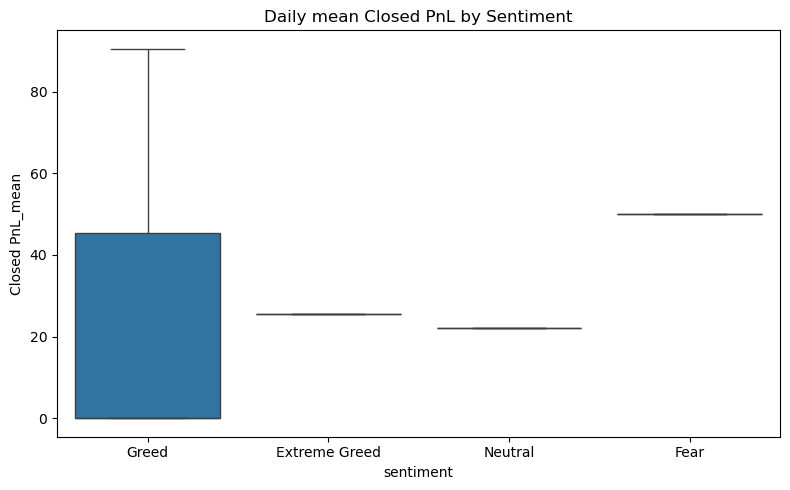

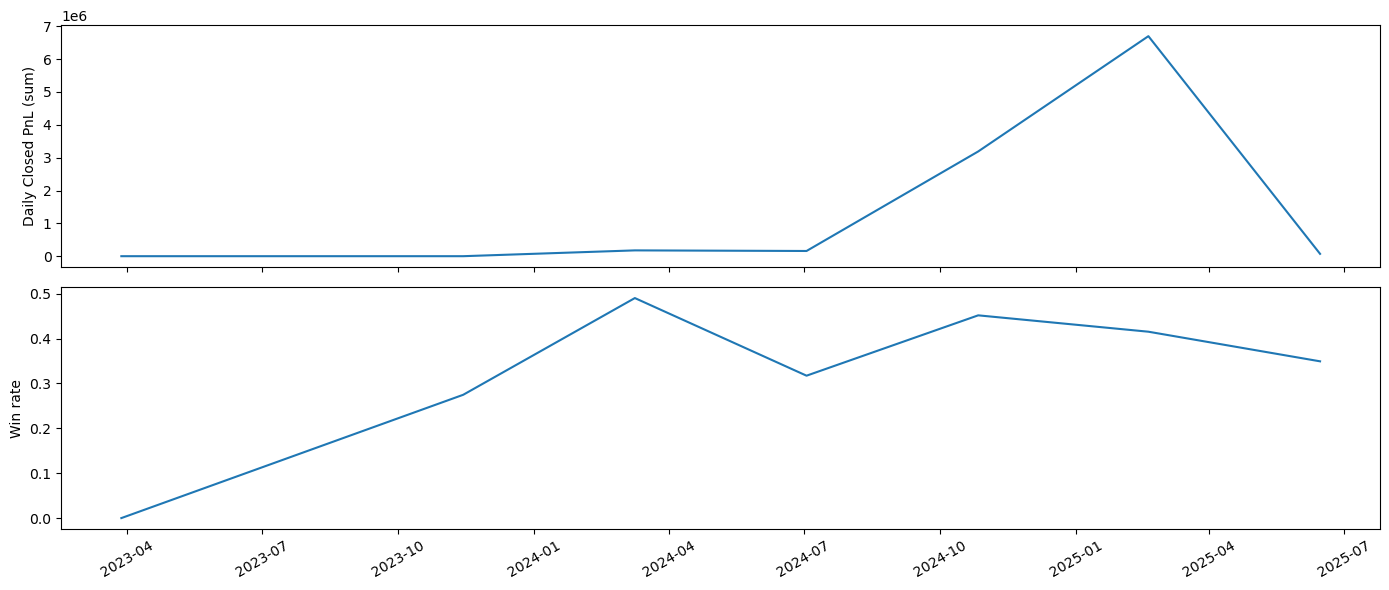

In [22]:
# Group comparison boxplot
plt.figure(figsize=(8,5))
# use the actual column name present in `merged`
sns.boxplot(x='sentiment', y='Closed PnL_mean', data=merged)
plt.title('Daily mean Closed PnL by Sentiment')
plt.tight_layout()
plt.show()

# Time series overlay
fig, ax = plt.subplots(2,1, figsize=(14,6), sharex=True)
# `Date_dt` was created earlier and is already datetime
ax[0].plot(merged['Date_dt'], merged['Closed PnL_sum'])
ax[0].set_ylabel('Daily Closed PnL (sum)')
ax[1].plot(merged['Date_dt'], merged['win_rate'])
ax[1].set_ylabel('Win rate')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=30)
plt.tight_layout()
plt.show()


In [23]:
from scipy.stats import ttest_ind, mannwhitneyu
import re

# normalize merged column names to safe snake_case identifiers (done once)
merged.columns = [re.sub(r'[^0-9a-zA-Z]+', '_', c).lower().strip('_') for c in merged.columns]

# now use the normalized name for the Closed PnL mean column
# expected normalized name: 'closed_pnl_mean' (from 'Closed PnL_mean')
if 'closed_pnl_mean' not in merged.columns:
	raise KeyError(f"Expected column 'closed_pnl_mean' not found in merged. Available columns: {merged.columns.tolist()}")

fear = merged[merged['sentiment'] == 'Fear']['closed_pnl_mean'].dropna()
greed = merged[merged['sentiment'] == 'Greed']['closed_pnl_mean'].dropna()
print('t-test:', ttest_ind(fear, greed, equal_var=False))
print('M-W U:', mannwhitneyu(fear, greed))


t-test: TtestResult(statistic=nan, pvalue=nan, df=1.0)
M-W U: MannwhitneyuResult(statistic=2.0, pvalue=1.0)


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [24]:
import statsmodels.formula.api as smf
# encode sentiment dummies
merged['sentiment_cat'] = merged['sentiment'].astype('category')

# build formula using predictors that actually exist in merged
predictors = []
if 'leverage_mean' in merged.columns:
	predictors.append('leverage_mean')
elif 'size_usd_mean' in merged.columns:
	predictors.append('size_usd_mean')
elif 'size_mean' in merged.columns:
	predictors.append('size_mean')

if 'account_nunique' in merged.columns:
	predictors.append('account_nunique')

if not predictors:
	raise KeyError(f"No numeric predictors found in merged. Available columns: {merged.columns.tolist()}")

formula = "closed_pnl_mean ~ C(sentiment_cat) + " + " + ".join(predictors)
print("Using formula:", formula)

res = smf.ols(formula, data=merged).fit()
print(res.summary())


Using formula: closed_pnl_mean ~ C(sentiment_cat) + size_usd_mean + account_nunique
                            OLS Regression Results                            
Dep. Variable:        closed_pnl_mean   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 24 Oct 2025   Prob (F-statistic):                nan
Time:                        07:14:12   Log-Likelihood:                 141.10
No. Observations:                   6   AIC:                            -270.2
Df Residuals:                       0   BIC:                            -271.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
